# Enviorment Setup 

Importing required libraries


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as display


AUTOTUNE = tf.data.experimental.AUTOTUNE

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

!pip install -U tensorflow-addons
import tensorflow_addons as tfa

     |████████████████████████████████| 686kB 12.5MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


Upziping the file to root directory

In [ ]:
import zipfile
with zipfile.ZipFile("./drive/MyDrive/Image_classification_data.zip", 'r') as zip_ref:
    zip_ref.extractall('./')

In [ ]:
df_main= pd.read_csv("./Image_classification_data/data_labels_mainData.csv")
df_extra= pd.read_csv("./Image_classification_data/data_labels_extraData.csv")

## Function definations

In [ ]:
#simple function to plot the learning curve of a NN training process to check overfitting and underfitting.
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, train_f1_score, val_f1_score):
    plt.figure(figsize=(10,5))
    
#Loss
    plt.subplot(1,3,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')
#Binary Accuracy
    plt.subplot(1,3,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Binary Accuracy")
    plt.ylim(0,1)
    plt.legend(['train', 'val'], loc='upper left')
#F1 Score
    plt.subplot(1,3,3)
    plt.plot(train_f1_score, 'r--')
    plt.plot(val_f1_score, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("F1_Score")
    plt.ylim(0,1)
    plt.legend(['train', 'val'], loc='upper left')
 
    plt.show()

In [ ]:
def plot_learning_curve2(train_loss, val_loss, train_metric, val_metric):
    plt.figure(figsize=(10,5))
    
#Loss
    plt.subplot(1,3,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')
#Sparse Categorical Accuracy
    plt.subplot(1,3,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Sparse Accuracy")
    plt.ylim(0,1)
    plt.legend(['train', 'val'], loc='upper left')
 
    plt.show()

In [ ]:
# Function to evaluate a model
def evaluate_model(modelEval, test_generator, flag):

   y_hat_all = list()
   y_all = list()
   filenames = test_generator.filenames
   N_images = len(filenames)
   batches = 0

   # iterate through the data generator and predict for each batch
   # hold the predictions and labels
   for x,y in test_generator:
        y_hat = modelEval.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)

        #for multi-class classification this line was throwing error
        if flag :
          y = np.argmax(y, axis = 1)
          
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / 1:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

    # now you have made the predictions you can use any performance metric
    # you wish: either in sklearn or some function you have written

   from sklearn.metrics import classification_report
   from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

   print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
   print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
   cf_matrix = confusion_matrix(y_all, y_hat_all)
   sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
   plt.xlabel("Predicted Label")
   plt.ylabel("Actual Label")


#CLASSIFICATION FOR CLASS 'isCancerous'

## Exploratory Data Analysis

In [ ]:
#combining both to learn a classifier for predicting is cancerous
frames = [df_main, df_extra]
df_comb = pd.concat(frames)
 
df_comb.drop('cellTypeName', axis=1, inplace=True)
df_comb.drop('cellType', axis=1, inplace=True)
df_comb.dtypes

InstanceID      int64
patientID       int64
ImageName      object
isCancerous     int64
dtype: object

(array([13211.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  7069.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

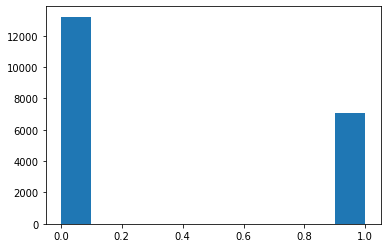

In [ ]:
#EDA
#Checking the distribution of the class in whole dataset, we can see class imbalance and ideally will take f1 score into consideration.
# since we are working with MLP we can not really rely on F1 hence we considered Recall.
plt.hist(df_comb['isCancerous'])

(array([ 188.,  296.,  783.,  650.,  366.,  332.,  741.,  483.,  630.,
         372.,  174.,  480.,  236.,  188.,  199.,  398.,  386.,  332.,
         253.,  334.,  659.,  521.,  504.,  276.,  322.,  131., 1071.,
         759.,  580.,   20.,   12., 1804.,  872.,  868.,  765., 1196.,
        1058.,  681.,   33.,  327.]),
 array([ 1.  ,  3.45,  5.9 ,  8.35, 10.8 , 13.25, 15.7 , 18.15, 20.6 ,
        23.05, 25.5 , 27.95, 30.4 , 32.85, 35.3 , 37.75, 40.2 , 42.65,
        45.1 , 47.55, 50.  , 52.45, 54.9 , 57.35, 59.8 , 62.25, 64.7 ,
        67.15, 69.6 , 72.05, 74.5 , 76.95, 79.4 , 81.85, 84.3 , 86.75,
        89.2 , 91.65, 94.1 , 96.55, 99.  ]),
 <a list of 40 Patch objects>)

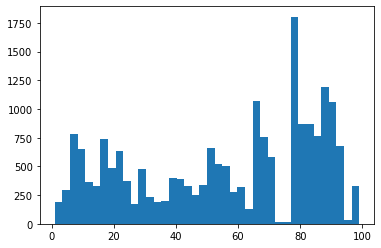

In [ ]:
#As we plot the patientid we noticed there are more than 1 images for a particular person.
#We can say we need to do a stratified split so our model is not biased and more robust.
patientid=df_comb['patientID']
plt.hist(patientid,bins=40)

Splitting the data-frame into train-validation-test data-frame implementing hold-out validation.
60-20-20


In [ ]:
#Stratified split
#This stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify.
#For example, if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones.
#stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.
 
train_data, test_data = train_test_split(df_comb, test_size=0.2, random_state=40, stratify=df_comb['isCancerous'])
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=40, stratify=train_data['isCancerous'])
print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))


Train data : 12168, Val Data: 4056, Test Data: 4056


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


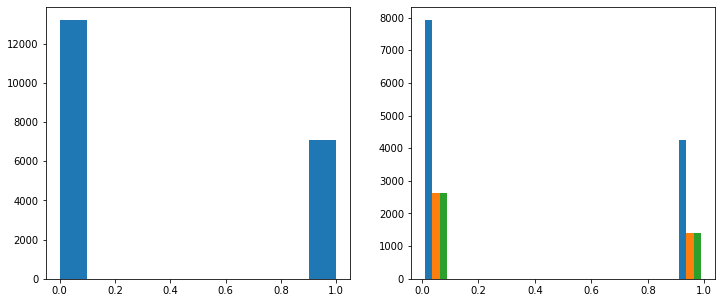

In [ ]:
#We can see that all our splits are stratified.
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(df_comb['isCancerous'])

plt.subplot(1,2,2)
splits= (train_data['isCancerous'], val_data['isCancerous'], test_data['isCancerous'])
plt.hist(splits, stacked=False)

plt.show()

In [ ]:
r_inx = np.random.choice(10, 4)
rand_data = df_comb.loc[r_inx,'ImageName']

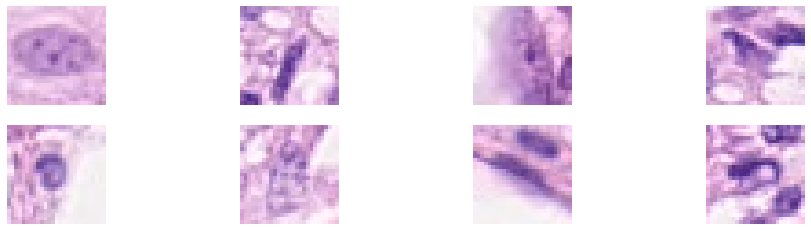

In [ ]:
from PIL import Image

plt.figure(figsize=(16,4))
for i, ImageName in enumerate(rand_data):
    im = np.asarray(Image.open('./Image_classification_data/patch_images/'+ ImageName))
    plt.subplot(2,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

In [ ]:
#Create the data generator for each split

train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')
test_data['isCancerous'] = test_data['isCancerous'].astype('str')
 
#Normalisation is used to rescale image in range of 0-1 to speed up the training process and reduce biasing.
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
 
batch_size = 32
 
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=1,
        class_mode='categorical')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


##Multi-Layer Percentron

### Baseline Model

In [ ]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2

In [ ]:
#Generally considered in the form of ( 2^x ). Also said to be in contrast to memory allocation in computers.
 
model_mlp = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid')
])

Reduction Type : https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class

In [ ]:
#Model compilation steps
model_mlp.compile(optimizer='sgd',
                  loss = tf.keras.losses.BinaryCrossentropy(),
                  metrics =[tf.metrics.BinaryAccuracy(),
                            tfa.metrics.F1Score(num_classes = 2, average="weighted")])

In [ ]:
history = model_mlp.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


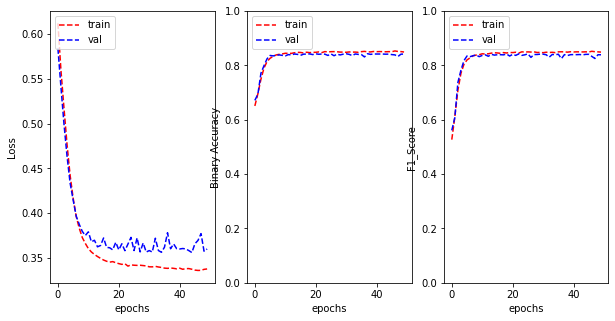

In [ ]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['binary_accuracy'], history.history['val_binary_accuracy'],
                    history.history['f1_score'], history.history['val_f1_score'])

###Hyperparameter tuning

In [ ]:
# 1 Regularization using l2 ridge regularisation.
# Added learning rate and momentum.
# we can explore lambda further by finding the value of  lamda by grid/random search cv

reg_lambda = 0.001

model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, 
                          activation='sigmoid', 
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, 
                          activation='sigmoid',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.5)

model_reg.compile(optimizer = optimizer,
                  loss = tf.keras.losses.BinaryCrossentropy(),
                  metrics =[tf.metrics.BinaryAccuracy(),
                             tfa.metrics.F1Score(num_classes = 2, average="weighted")])

In [ ]:
history = model_reg.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


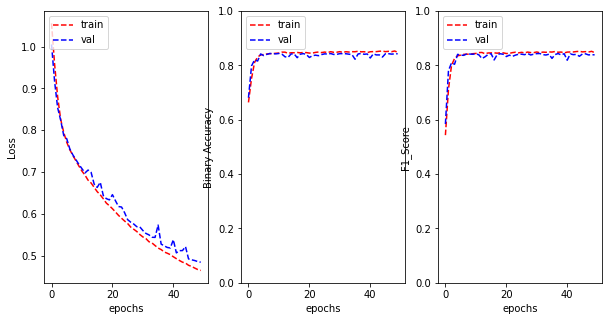

In [ ]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['binary_accuracy'], history.history['val_binary_accuracy'],
                    history.history['f1_score'], history.history['val_f1_score'])

In [ ]:
#Model with regularisation + Dropout
model_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, 
                          activation='sigmoid', 
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(OUTPUT_CLASSES,
                          activation='sigmoid',
                          kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

model_drop.compile(optimizer= optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics =[tf.metrics.BinaryAccuracy(),
                         tfa.metrics.F1Score(num_classes = 2, average="weighted")])

In [ ]:
history = model_drop.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


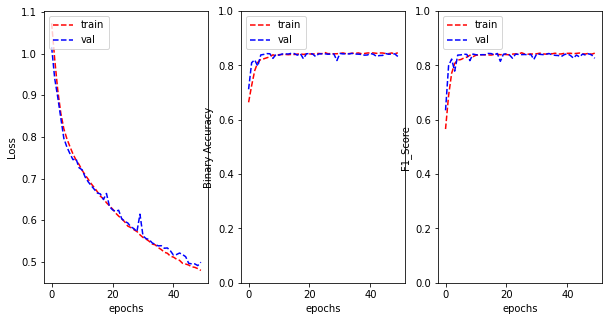

In [ ]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['binary_accuracy'], history.history['val_binary_accuracy'],
                    history.history['f1_score'], history.history['val_f1_score'])

### Final Model Shape

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               560128    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514       
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


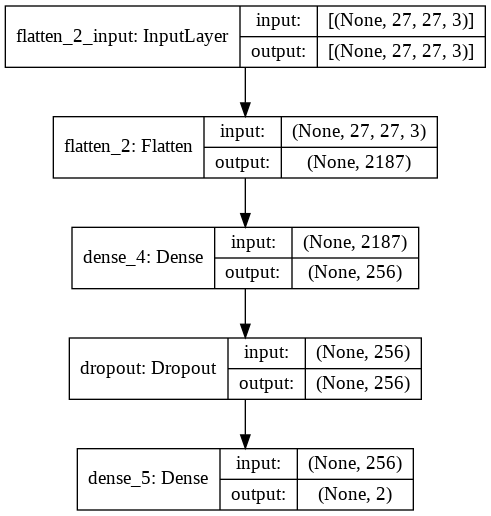

In [ ]:
model_drop.summary()
tf.keras.utils.plot_model(model_drop, show_shapes=True)

###Evaluating Final MLP model


In [ ]:
model_drop.evaluate(test_generator)

  45/4056 [..............................] - ETA: 14s - loss: 0.6071 - binary_accuracy: 0.8000 - f1_score: 0.7894

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


4056/4056 [==============================] - 14s 3ms/step - loss: 0.4948 - binary_accuracy: 0.8426 - f1_score: 0.8364


[0.4947817325592041, 0.8425788879394531, 0.8364331126213074]

Accuracy score:  0.8427021696252466
F1 score:  0.8145627405634905


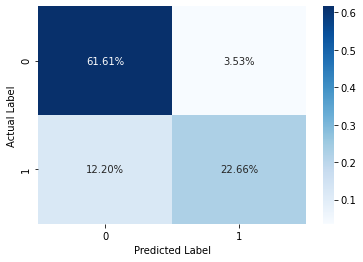

In [ ]:
evaluate_model(model_drop, test_generator, True)

## CNN Model (VGG)

### Baseline Model

BaseLine Model
Aiming for an reliable model with aleast 70% accuracy and overall Recall of less then 1

In [ ]:
model_VGG_base = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #VGG block 4
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation = 'softmax'),
])

In [ ]:
model_VGG_base.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics =[tf.metrics.BinaryAccuracy(),
                        tfa.metrics.F1Score(num_classes = 2, average="weighted")])

In [ ]:
history_VGG_base = model_VGG_base.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


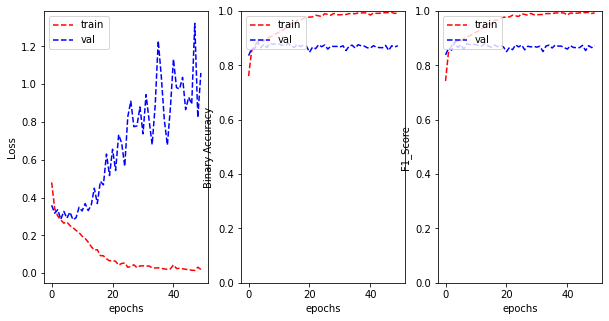

In [ ]:
plot_learning_curve(history_VGG_base.history['loss'], history_VGG_base.history['val_loss'], 
                    history_VGG_base.history['binary_accuracy'], history_VGG_base.history['val_binary_accuracy'],
                    history_VGG_base.history['f1_score'], history_VGG_base.history['val_f1_score'])

###Hyperparameter Tuning

Implemeting Weight Regularization, maxpooling and Dropout

In [ ]:
#Weight Regularisation + Dropout in every layer.

reg_lambda = 0.01

model_VGG_hyper = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #VGG block 4
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax'),
])

In [ ]:
model_VGG_hyper.compile(optimizer= tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics =[tf.metrics.BinaryAccuracy(),
                         tfa.metrics.F1Score(num_classes = 2, average="weighted")])

In [ ]:
history_VGG_hyper = model_VGG_hyper.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


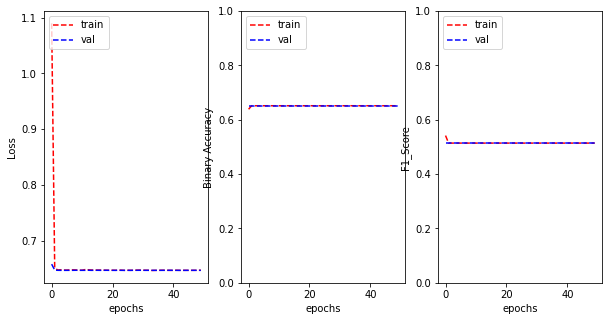

In [ ]:
plot_learning_curve(history_VGG_hyper.history['loss'], history_VGG_hyper.history['val_loss'], 
                    history_VGG_hyper.history['binary_accuracy'], history_VGG_hyper.history['val_binary_accuracy'],
                    history_VGG_hyper.history['f1_score'], history_VGG_hyper.history['val_f1_score'])

Implementing data augmentation and class weights

In [ ]:
#Learning rate + Data Augmentation 
train_datagen = ImageDataGenerator(rescale=1./255,
                                   data_format='channels_last',
                                   rotation_range=45,
                                   width_shift_range=0.25,
                                   height_shift_range=0.25,
                                   brightness_range=[0.5,1.5],
                                   horizontal_flip = True,
                                   vertical_flip = True)

val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe= val_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [ ]:
reg_lambda = 0.005

model_VGG_dataAug = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #VGG block 4
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(2, activation='softmax'),
])

In [ ]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.767503469156049, 1: 1.434567319028531}

In [ ]:
model_VGG_dataAug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics =[tf.metrics.BinaryAccuracy(),
                        tfa.metrics.F1Score(num_classes = 2, average="weighted")])

In [ ]:
history_VGG_dataAug = model_VGG_dataAug.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0, class_weight= class_weights)


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


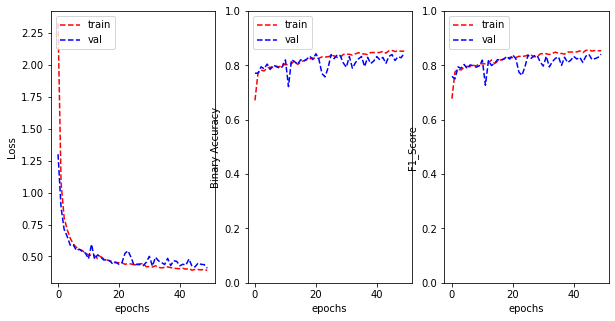

In [ ]:
plot_learning_curve(history_VGG_dataAug.history['loss'], history_VGG_dataAug.history['val_loss'], 
                    history_VGG_dataAug.history['binary_accuracy'], history_VGG_dataAug.history['val_binary_accuracy'],
                    history_VGG_dataAug.history['f1_score'], history_VGG_dataAug.history['val_f1_score'])

### Final Model Shape

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 6, 6, 128)        

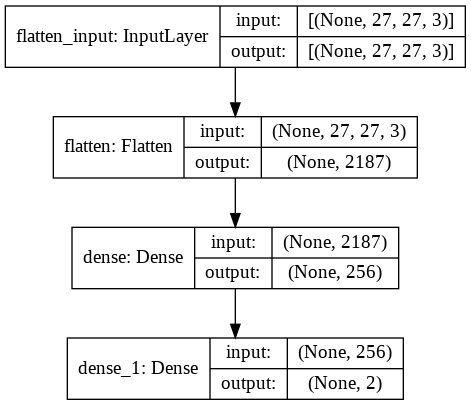

In [ ]:
model_VGG_dataAug.summary()
tf.keras.utils.plot_model(model_mlp, show_shapes=True)

### Evaluating Final CNN Model

In [ ]:
model_VGG_dataAug.evaluate(test_generator)

  10/4056 [..............................] - ETA: 24s - loss: 0.4508 - binary_accuracy: 0.8000 - f1_score: 0.7810 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


4056/4056 [==============================] - 22s 5ms/step - loss: 0.4033 - binary_accuracy: 0.8536 - f1_score: 0.8502


[0.40333232283592224, 0.8535503149032593, 0.8501578569412231]

Accuracy score:  0.8535502958579881
F1 score:  0.8318867924528303


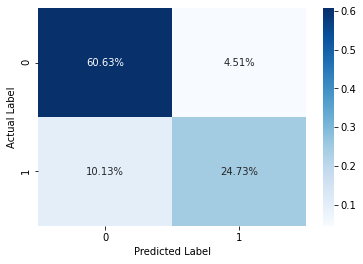

In [ ]:
evaluate_model(model_VGG_dataAug, test_generator, True)

###Saving Model

In [ ]:
model_VGG_dataAug.save('predictCancer')

INFO:tensorflow:Assets written to: predictCancer/assets


#CLASSIFICATION FOR CLASS 'cellType'

### Exploratory Data Analysis

(array([1888.,    0.,    0., 2543.,    0.,    0., 4079.,    0.,    0.,
        1386.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

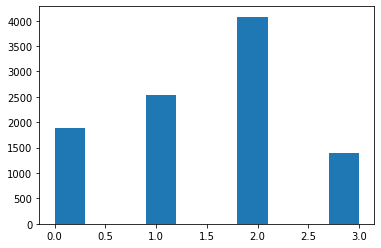

In [ ]:
#Checking the distribution of the class, we can see class imbalance and ideally will take f1 score into consideration.
# we considered Recall and Accuracy.
plt.hist(df_main['cellType'])

In [ ]:
#Stratified split
train_data_cell, test_data_cell = train_test_split(df_main, test_size=0.2, random_state=40, stratify=df_main['cellType'])
train_data_cell, val_data_cell = train_test_split(train_data_cell, test_size=0.25, random_state=40, stratify=train_data_cell['cellType'])
print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data_cell.shape[0], val_data_cell.shape[0], test_data_cell.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


## CNN Model(Transfer Learning)

### Baseline Model

In [ ]:
train_data_cell['cellType'] = train_data_cell['cellType'].astype('str')
val_data_cell['cellType'] = val_data_cell['cellType'].astype('str')
test_data_cell['cellType'] = test_data_cell['cellType'].astype('str')
 
#Normalisation is used to rescale image in range of 0-1 to speed up the training process and reduce biasing.
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
 
batch_size = 32
 
train_generator_cell = train_datagen.flow_from_dataframe(
        dataframe=train_data_cell,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')
 
validation_generator_cell = val_datagen.flow_from_dataframe(
        dataframe=val_data_cell,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

test_generator_cell = test_datagen.flow_from_dataframe(
        dataframe=test_data_cell,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=1,
        class_mode='sparse')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#Transfer learning
model_cell_base = tf.keras.models.Sequential(model_VGG_dataAug.layers[:-1])


In [ ]:
model_cell_base.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 6, 6, 128)        

In [ ]:
OUTPUT_CLASSES = 4
model_cell_base.add(tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax'))

In [ ]:
model_cell_base.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 6, 6, 128)        

In [ ]:
model_cell_base.compile(optimizer = tf.keras.optimizers.Adam(),
                        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics =[tf.metrics.SparseCategoricalAccuracy()])

In [ ]:
history_VGG_base = model_cell_base.fit(train_generator_cell, validation_data = validation_generator_cell, epochs=50, verbose=0)

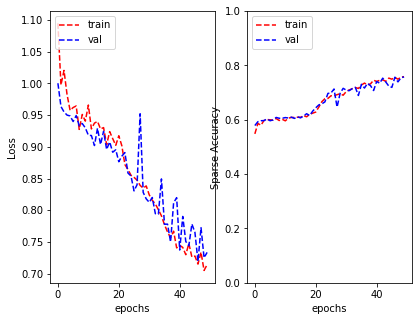

In [ ]:
plot_learning_curve2(history_VGG_base.history['loss'], history_VGG_base.history['val_loss'], 
                    history_VGG_base.history['sparse_categorical_accuracy'], history_VGG_base.history['val_sparse_categorical_accuracy'])

### Testing Base Model

In [ ]:
model_cell_base.evaluate(test_generator_cell)

1980/1980 [==============================] - 10s 5ms/step - loss: 0.7562 - sparse_categorical_accuracy: 0.7465


[0.7561764717102051, 0.7464646697044373]

Accuracy score:  0.7464646464646465
F1 score:  0.6641375428929064


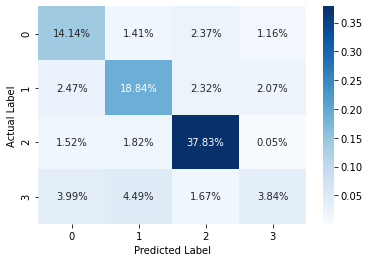

In [ ]:
evaluate_model(model_cell_base, test_generator_cell, False)

###Hyperparameter tuning

Adding weights for respective class 

In [ ]:
class_weights_cell = class_weight.compute_class_weight('balanced', np.unique(train_generator_cell.classes), train_generator_cell.classes)
class_weights_cell = dict(enumerate(class_weights_cell))
class_weights_cell

{0: 1.3111749116607774,
 1: 0.9726408912188729,
 2: 0.606559051900286,
 3: 1.7839543269230769}

In [ ]:
model_cell_base.compile(optimizer = tf.keras.optimizers.Adam(),
                        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics =[tf.metrics.SparseCategoricalAccuracy()])

In [ ]:
history_hyper = model_cell_base.fit(train_generator_cell, validation_data = validation_generator_cell, epochs=50, verbose=0, class_weight= class_weights_cell)


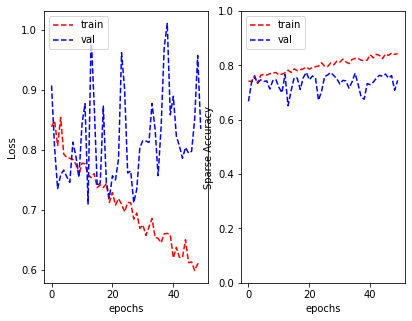

In [ ]:
plot_learning_curve2(history_hyper.history['loss'], history_hyper.history['val_loss'], 
                    history_hyper.history['sparse_categorical_accuracy'], history_hyper.history['val_sparse_categorical_accuracy'])

### Evaluating Final Model

In [ ]:
model_cell_base.evaluate(test_generator_cell)

1980/1980 [==============================] - 10s 5ms/step - loss: 0.8089 - sparse_categorical_accuracy: 0.7480


[0.8088731169700623, 0.7479798197746277]

Accuracy score:  0.747979797979798
F1 score:  0.707292794374137


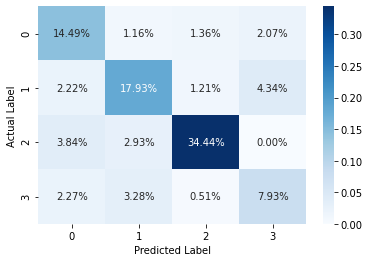

In [ ]:
evaluate_model(model_cell_base, test_generator_cell, False)

###Saving Model

In [ ]:
model_cell_base.save("model_VGG_cell")

INFO:tensorflow:Assets written to: model_VGG_cell/assets
